In [51]:
from lsst.daf.butler import Butler
from lsst.meas.algorithms import ReferenceObjectLoader
import lsst.geom
import lsst.afw.geom as afwgeom

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from astropy.time import Time
import astropy.units as u
from astropy.coordinates import SkyCoord

## Set up the `butler` that will fetch the data:

In [4]:
butler = Butler('/repo/embargo', collections='u/csaunder/DM-41130/dev3_vis1')

In [43]:
# The sky is split into "tracts", which are further split into "patches". The "skymap" determines how this is done. I'm not using it
# anywhere in this analysis, but it has some helpful functions.
skymap = butler.get('skyMap', skymap='latiss_v1')

## There are a couple ways to get information about the visits (aka exposures)

### The `visitTable` gives an overview of the conditions for a given visit:

In [49]:
visitTable = butler.get('visitTable')
visitTable

,visit,physical_filter,band,ra,dec,decl,skyRotation,azimuth,altitude,zenithDistance,airmass,expTime,expMidpt,expMidptMJD,obsStart,obsStartMJD
visitId,,,,,,,,,,,,,,,,
2023051100262,2023051100262,SDSSr_65mm~empty,r,239.941279,-24.050861,-24.050861,322.911701,100.652699,33.079204,56.920796,1.826588,30.0,2023-05-12 01:08:56.302993,60076.047874,2023-05-12 01:08:41.302993,60076.047700
2023051100263,2023051100263,SDSSg_65mm~empty,g,239.943099,-24.042851,-24.042851,170.005077,100.427273,33.535722,56.464278,1.804276,30.0,2023-05-12 01:11:06.209005,60076.049377,2023-05-12 01:10:51.209005,60076.049204
2023051100264,2023051100264,SDSSi_65mm~empty,i,239.940919,-24.040927,-24.040927,170.004955,100.024337,34.385246,55.614754,1.765315,30.0,2023-05-12 01:15:04.912000,60076.052140,2023-05-12 01:14:49.912000,60076.051967
2023051100268,2023051100268,SDSSr_65mm~empty,r,239.960079,-24.042010,-24.042010,323.867206,99.573769,35.343223,54.656777,1.724092,30.0,2023-05-12 01:19:39.311494,60076.055316,2023-05-12 01:19:24.311494,60076.055142
2023051100269,2023051100269,SDSSg_65mm~empty,g,239.959845,-24.048026,-24.048026,170.004092,99.360495,35.811664,54.188336,1.704281,30.0,2023-05-12 01:21:49.752999,60076.056826,2023-05-12 01:21:34.752999,60076.056652
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023091400082,2023091400082,SDSSr_65mm~empty,r,270.194112,-24.950260,-24.950260,359.998802,263.701292,44.750180,45.249820,1.417337,30.0,2023-09-15 02:35:28.260509,60202.107966,2023-09-15 02:35:13.260509,60202.107792
2023091400083,2023091400083,SDSSr_65mm~empty,r,270.210518,-24.950264,-24.950264,359.998614,263.622517,44.584958,45.415042,1.421490,30.0,2023-09-15 02:36:18.753500,60202.108550,2023-09-15 02:36:03.753500,60202.108377
2023091400084,2023091400084,SDSSr_65mm~empty,r,270.226810,-24.950250,-24.950250,359.998689,263.542128,44.416073,45.583927,1.425701,30.0,2023-09-15 02:37:09.293010,60202.109135,2023-09-15 02:36:54.293010,60202.108962


### The visit summaries have more in-depth info:
I'm going to use the visit summaries below, mostly because I can be sure I am grabbing the same visits that went into the astrometric fit for the band and tract that I am looking at here.

In [45]:
visitSummaryRefs = list(butler.registry.queryDatasets('visitSummary', tract=5634, band='r', skymap='latiss_v1'))
visits = np.array([visRef.dataId['visit'] for visRef in visitSummaryRefs])
visitSummaries = [butler.get(visitSummaryRefs[v]) for v in visits.argsort()]
print(f'Tract 5634 has {len(visits)} visits (aka exposures) in r-band')

Tract 5634 has 374 visits (aka exposures) in r-band


In [48]:
# Here's an example visitSummary. There's one row per detector--LATISS is only one detector, so this is a one-row table.
visitSummaries[0]

<class 'lsst.afw.table.ExposureCatalog'>
 id bbox_min_x bbox_min_y ... psfTraceRadiusDelta maxDistToNearestPsf
       pix        pix     ...                                        
--- ---------- ---------- ... ------------------- -------------------
  0          0          0 ...          0.05838635             768.489

In [50]:
# Build a list that we can use to go from the extension index to the visit and detector. I have this sorted in the same way that it
# is done in gbdesAstrometricFit, so this list will give us a key to what the "catalogNumber" indices below refer to.
extensionVisits = []
extensionDetectors = []
for visSum in visitSummaries:
    for row in visSum:
        extensionVisits.append(row['visit'])
        extensionDetectors.append(row['id'])

extensionInfo = pd.DataFrame({'visit': extensionVisits,
                              'detector': extensionDetectors})


In [18]:
# For a given row of a visitSummary, you can access the "visitInfo", which is the same for each row because they all correspond to
# the same visit. The visitInfo has lots of helpful information.
visSum = visitSummaries[0]
visInfo = visSum[0].getVisitInfo()
visInfo.getScienceProgram()

'AUXTEL_PHOTO_IMAGING'

In [56]:
# Build another table of some helpful information about the visits that went into the astrometric fit.
visits = []
altitudes = []
airmasses = []
mjds = []
ras = []
decs = []
for visSum in visitSummaries:
    visits.append(visSum['visit'][0])
    visInfo = visSum[0].getVisitInfo()
    alt = visInfo.boresightAzAlt.getLatitude().asDegrees()
    altitudes.append(alt)
    airmass = visInfo.boresightAirmass
    airmasses.append(airmass)
    mjd = visInfo.date.get(visInfo.date.MJD)
    mjds.append(mjd)
    raDec = visInfo.boresightRaDec
    ras.append(raDec.getRa().asDegrees())
    decs.append(raDec.getDec().asDegrees())
visitInfo = pd.DataFrame({'visit': visits, 'altitude': altitudes, 'airmass': airmasses,
                          'mjd': mjds, 'ra': ras, 'dec': decs}) 
visitInfo

,visit,altitude,airmass,mjd,ra,dec
0,2023052300621,69.638090,1.066195,60088.215718,270.144118,-25.049109
1,2023052300626,70.431618,1.060891,60088.218336,270.160268,-25.049147
2,2023052300632,71.915991,1.051593,60088.223235,270.176475,-25.049132
3,2023052300645,74.520799,1.037341,60088.231879,270.192944,-25.049119
4,2023052300655,76.330875,1.028910,60088.238001,270.209295,-25.049111
...,...,...,...,...,...,...
369,2023091400082,44.750180,1.417337,60202.107966,270.194112,-24.950260
370,2023091400083,44.584958,1.421490,60202.108550,270.210518,-24.950264
371,2023091400084,44.416073,1.425701,60202.109135,270.226810,-24.950250
372,2023091400085,44.247203,1.429949,60202.109721,270.243077,-24.950268


Text(0.5, 1.0, 'Altitudes for all r-band exposures in tract 5634')

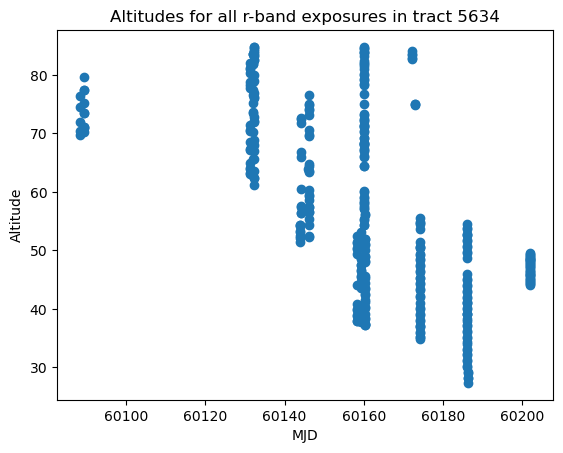

In [57]:
plt.scatter(mjds, altitudes)
plt.xlabel('MJD')
plt.ylabel('Altitude')
plt.title('Altitudes for all r-band exposures in tract 5634')

Text(0.5, 1.0, 'Airmasses for all r-band exposures in tract 5634')

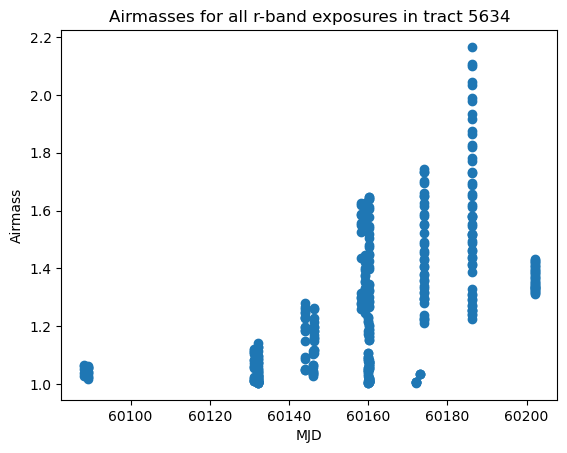

In [58]:
plt.scatter(mjds, airmasses)
plt.xlabel('MJD')
plt.ylabel('Airmass')
plt.title('Airmasses for all r-band exposures in tract 5634')

## Now let's look at the output of the astrometric fit:

In [8]:
# N.B. you can use butler.registry.queryDatasetTypes() to get information about dataset types:
butler.registry.queryDatasetTypes('gbdes*')

[DatasetType('gbdesAstrometricFit_config', {}, Config),
 DatasetType('gbdesAstrometricFit_starCatalog', {band, instrument, skymap, physical_filter, tract}, ArrowNumpyDict),
 DatasetType('gbdesAstrometricFitSkyWcsCatalog', {band, instrument, skymap, physical_filter, tract, visit}, ExposureCatalog),
 DatasetType('gbdesAstrometricFit_fitStars', {band, instrument, skymap, physical_filter, tract}, ArrowNumpyDict),
 DatasetType('gbdesAstrometricFit_metadata', {band, instrument, skymap, physical_filter, tract}, TaskMetadata),
 DatasetType('gbdesAstrometricFit_log', {band, instrument, skymap, physical_filter, tract}, ButlerLogRecords)]

In [53]:
# Use queryDatasets to see what gbdesAstrometricFit_starCatalog outputs exist. What you see below is that I ran the astrometric fitter
# on the r band of tracts 5615 and 5634 multiple times. The butler stored the output of all these runs with a timestamp on the end of
# the collection name. When you run butler.get(), you will automatically get the latest run, unless you specifically request another.
list(butler.registry.queryDatasets('gbdesAstrometricFit_starCatalog'))

[DatasetRef(DatasetType('gbdesAstrometricFit_starCatalog', {band, instrument, skymap, physical_filter, tract}, ArrowNumpyDict), {instrument: 'LATISS', skymap: 'latiss_v1', physical_filter: 'SDSSr_65mm~empty', tract: 5615, ...}, run='u/csaunder/DM-41130/dev3_vis1/20231027T161450Z', id=5abfc877-b057-441d-b995-2d33a321e552),
 DatasetRef(DatasetType('gbdesAstrometricFit_starCatalog', {band, instrument, skymap, physical_filter, tract}, ArrowNumpyDict), {instrument: 'LATISS', skymap: 'latiss_v1', physical_filter: 'SDSSr_65mm~empty', tract: 5634, ...}, run='u/csaunder/DM-41130/dev3_vis1/20231027T161450Z', id=25548cdb-17a4-440d-92c8-4d985d53dd02),
 DatasetRef(DatasetType('gbdesAstrometricFit_starCatalog', {band, instrument, skymap, physical_filter, tract}, ArrowNumpyDict), {instrument: 'LATISS', skymap: 'latiss_v1', physical_filter: 'SDSSr_65mm~empty', tract: 5615, ...}, run='u/csaunder/DM-41130/dev3_vis1/20231031T203849Z', id=d65e97e6-3bc4-4438-ba20-84779b3444e2),
 DatasetRef(DatasetType('gbd

## Get the catalog of the best fit of the objects used in the astrometric fit:
Here's a description of the columns:

•	starMatchID - the id of this source

•	starReserve - if True, this star was reserved for validation and was not used in the fit.

•	starColor - color, will be filled in when we actually use color in the fit.

•	starPMCount - number of sources for this star that had proper motion/parallax information (this will always be zero when proper motion fitting is turned off, even though the Gaia stars do have proper motion information)

•	starDetCount - number of sources for this star not counting those with proper motion/parallax information

•	starClipCount - how many of this object's sources were clipped

•	starDOF - degrees of freedom of the position fit

•	starChisq - chi-squared value for the position fit

•	starX - best-fit RA in degrees

•	starY - best-fit Dec in degrees

•	starPMx - best-fit proper motion in RA in milliarcseconds / year

•	starPMy - best-fit proper motion in Dec in milliarcseconds / year

•	starParallax - best-fit parallax in milliarcseconds

•	starInvCov - inverse covaraiance matrix -- stored flat, so you need to reshape the arrays to (2,2) for fits without PM or to (5,5) for fits with PM

In [23]:
starCatDict = butler.get('gbdesAstrometricFit_starCatalog', skymap='latiss_v1', tract=5634, physical_filter='SDSSr_65mm~empty')
starCatDict['starInvCov'] = starCatDict['starInvCov'].tolist()
starCat = pd.DataFrame(starCatDict)
starCat

,starMatchID,starReserve,starColor,starPMCount,starDetCount,starClipCount,starDOF,starChisq,starX,starY,starPMx,starPMy,starParallax,starInvCov
0,0,False,-888.0,0,2,0,2,4.386844,-89.929544,-24.994483,0.0,0.0,0.0,"[0.5606299583452715, -0.00287514863800916, -0...."
1,1,False,-888.0,0,2,0,2,1.449038,-89.926920,-25.020756,0.0,0.0,0.0,"[1.1770725331311531, -0.00831149871846034, -0...."
2,2,False,-888.0,0,2,0,2,0.046936,-89.926137,-24.935999,0.0,0.0,0.0,"[3.2371116852659445, -0.020032877183524308, -0..."
3,3,False,-888.0,0,2,0,2,4.761145,-89.926204,-25.054878,0.0,0.0,0.0,"[1.8087929221032, -0.010619721657492457, -0.01..."
4,4,False,-888.0,0,2,0,2,1.084361,-89.925627,-25.022477,0.0,0.0,0.0,"[15.356696943370924, -0.0717498846590493, -0.0..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4623,4623,False,-888.0,0,2,0,2,3.483348,-89.678526,-25.014572,0.0,0.0,0.0,"[0.768501828378629, -0.0052839259527495954, -0..."
4624,4624,False,-888.0,0,2,0,2,1.342775,-89.678551,-24.991095,0.0,0.0,0.0,"[0.8415519987096797, -0.005598865929983926, -0..."
4625,4625,True,-888.0,0,3,0,4,4.572888,-89.678303,-25.055037,0.0,0.0,0.0,"[0.9406979550948308, -0.007149478499763768, -0..."
4626,4626,False,-888.0,0,2,0,2,0.401067,-89.678008,-25.058063,0.0,0.0,0.0,"[1.6673737329229685, -0.009711436875619893, -0..."


## Get the table of all the source measurements
Here's a description of the columns:

•	matchId – The id of the object (i.e. the star) corresponding to this source (this corresponds to "starMatchID" in the starCatalog table)

•	catalogNumber – The index of the extension (a single detector from one exposure) of the source

•	reserve – Was this source used in the fit or reserved for validation

•	clip – Was this source clipped from the fit (if True, probably shouldn’t use this source for analysis)

•	xpix, ypix – x and y pixel coordinates of the source

•	xrespix, yrespix – residuals in pixel coordinates

•	xworld, yworld – x and y coordinates in the plane tangent to the field center

•	xresw, yresw – residuals in the plane tangent to the field center. This is very close to RA and Dec, so you can use these in place of residuals in RA/Dec

•	chisq – chi-squared value of the fit

•	color – color of the source. We don’t have this information currently, but it will be interesting to look at once we do.


In [55]:
starResiduals = pd.DataFrame(butler.get('gbdesAstrometricFit_fitStars', skymap='latiss_v1', tract=5634, physical_filter='SDSSr_65mm~empty'))
starResiduals

,matchID,catalogNumber,objectNumber,clip,reserve,hasPM,color,xresw,yresw,xpix,...,sigpix,xrespix,yrespix,xworld,yworld,chisq,chisqExpected,covTotalW_00,covTotalW_11,covTotalW_01
0,0,351,11934,False,False,False,-888.0,-0.043829,0.006742,270.070456,...,3.344196e-07,360.000000,1.884157e-09,-0.114716,0.005034,0.001125,0.000469,1.784286,0.967478,0.005022
1,0,232,195,False,False,False,-888.0,156.533523,-75.743863,53.088194,...,8.124678e-01,1.624860,-8.126504e-01,-0.114673,0.005013,4.385719,1.999531,6006.533080,6343.915098,-1249.814082
2,1,351,11709,False,False,False,-888.0,-0.019069,0.000122,270.073080,...,2.363627e-07,360.000000,3.871037e-11,-0.112313,-0.021237,0.000428,0.000492,0.849885,0.506651,0.003632
3,1,232,130,False,False,False,-888.0,64.044084,-28.814364,129.341398,...,5.847506e-01,0.665100,-3.097465e-01,-0.112296,-0.021245,1.448610,1.999508,2832.525112,3981.424919,-1212.919252
4,2,351,13162,False,False,False,-888.0,0.001060,-0.002823,270.073863,...,1.426319e-07,360.000000,-7.842971e-10,-0.111680,0.063520,0.000047,0.002587,0.309414,0.184799,0.001165
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87070,4625,51,20,False,True,False,-888.0,-69.863689,-30.391452,3956.538712,...,5.242865e-01,-0.734229,-3.082736e-01,0.112922,-0.055527,3.646678,1.999182,1813.817143,3770.791711,-710.840919
87071,4626,351,2239,False,False,False,-888.0,0.001049,-0.001988,270.321992,...,1.950407e-07,360.000000,-5.518999e-10,0.113205,-0.058545,0.000014,0.000121,0.599803,0.332676,0.001947
87072,4626,51,13,False,False,False,-888.0,-34.475793,56.818422,3965.410349,...,9.456592e-01,-0.352820,5.981946e-01,0.113196,-0.058529,0.401053,1.999879,8952.814953,8572.326778,-3114.976318
87073,4627,351,2859,False,False,False,-888.0,0.016453,0.006740,270.322229,...,8.254302e-08,360.000000,1.876387e-09,0.113457,-0.018422,0.003403,0.002103,0.100419,0.063785,0.000147


#### Get all the reference sources that went into the fit (note proper motion and parallax values are not included in this table but are available elsewhere):

In [58]:
# The highest "catalogNumber" always refers to the reference catalog, so we can use that to find which sources come from 
# the reference catalog
refId = starResiduals['catalogNumber'].max()
starResiduals[starResiduals['catalogNumber'] == refId]

,matchID,catalogNumber,objectNumber,clip,reserve,hasPM,color,xresw,yresw,xpix,...,sigpix,xrespix,yrespix,xworld,yworld,chisq,chisqExpected,covTotalW_00,covTotalW_11,covTotalW_01
0,0,351,11934,False,False,False,-888.0,-0.043829,0.006742,270.070456,...,3.344196e-07,360.0,1.884157e-09,-0.114716,0.005034,0.001125,0.000469,1.784286,0.967478,0.005022
2,1,351,11709,False,False,False,-888.0,-0.019069,0.000122,270.073080,...,2.363627e-07,360.0,3.871037e-11,-0.112313,-0.021237,0.000428,0.000492,0.849885,0.506651,0.003632
4,2,351,13162,False,False,False,-888.0,0.001060,-0.002823,270.073863,...,1.426319e-07,360.0,-7.842971e-10,-0.111680,0.063520,0.000047,0.002587,0.309414,0.184799,0.001165
6,3,351,5069,False,False,False,-888.0,0.020903,-0.004087,270.073796,...,1.942291e-07,360.0,-1.140499e-09,-0.111633,-0.055359,0.000839,0.000297,0.552999,0.354840,0.002091
8,4,351,11669,False,False,False,-888.0,0.002955,0.002904,270.074373,...,6.590681e-08,360.0,8.058159e-10,-0.111140,-0.022957,0.000344,0.000595,0.065141,0.039958,0.000189
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87064,4623,351,2825,False,False,False,-888.0,0.036258,-0.011743,270.321474,...,2.921481e-07,360.0,-3.252719e-09,0.112776,-0.015054,0.001193,0.000562,1.301662,0.772262,0.005137
87066,4624,351,3370,False,False,False,-888.0,0.005899,-0.008822,270.321449,...,2.793063e-07,360.0,-2.449038e-09,0.112775,0.008424,0.000140,0.000250,1.188487,0.706890,0.004711
87068,4625,351,2282,False,True,False,-888.0,0.054638,0.003474,270.321697,...,2.652190e-07,360.0,9.791066e-10,0.112941,-0.055519,0.002822,0.001025,1.063870,0.641341,0.004914
87071,4626,351,2239,False,False,False,-888.0,0.001049,-0.001988,270.321992,...,1.950407e-07,360.0,-5.518999e-10,0.113205,-0.058545,0.000014,0.000121,0.599803,0.332676,0.001947


### To get the visit corresponding to a given source in the starResiduals table:


In [92]:
exampleStarResidual = starResiduals.iloc[0]
correspondingExtension = extensionInfo.iloc[exampleStarResidual['catalogNumber']]
visInfo = visitInfo[visitInfo['visit'] == correspondingExtension['visit']].iloc[0]
print(f"The source at index 0 is from visit {correspondingExtension['visit']} and detector {correspondingExtension['detector']}",
     f"at airmass {visInfo['airmass']:.3f}")
 

The source at index 0 is from visit 2023091400064 and detector 0 at airmass 1.344


### To get the star that corresponds to a given source measurement and vice versa:

In [36]:
exampleStarResidual = starResiduals.iloc[0]
correspondingStar = starCat[starCat['starMatchID'] == exampleStarResidual['matchID']]
correspondingStar

,starMatchID,starReserve,starColor,starPMCount,starDetCount,starClipCount,starDOF,starChisq,starX,starY,starPMx,starPMy,starParallax,starInvCov
0,0,False,-888.0,0,2,0,2,4.386844,-89.929544,-24.994483,0.0,0.0,0.0,"[0.5606299583452715, -0.00287514863800916, -0...."


In [37]:
exampleStar = starCat.iloc[100]
correspondingResiduals = starResiduals[starResiduals['matchID'] == exampleStar['starMatchID']]
correspondingResiduals

,matchID,catalogNumber,objectNumber,clip,reserve,hasPM,color,xresw,yresw,xpix,...,sigpix,xrespix,yrespix,xworld,yworld,chisq,chisqExpected,covTotalW_00,covTotalW_11,covTotalW_01
390,100,351,5083,False,False,False,-888.0,-0.043112,0.466457,270.088420,...,7.816954e-07,360.000000,1.295807e-07,-0.098387,-0.052954,0.038981,0.009913,9.167839,5.615742,0.040616
391,100,0,89,False,False,False,-888.0,1.311784,-108.680123,3874.441833,...,1.230175e+00,0.100367,1.131267e+00,-0.098387,-0.052985,2.375183,1.998584,38432.108440,6330.105512,7162.318131
392,100,9,458,False,False,False,-888.0,-27.342269,-0.595576,3924.054872,...,7.300376e-01,0.285822,2.401485e-03,-0.098395,-0.052955,0.146780,1.996982,5277.145516,4636.904199,-812.050804
393,100,192,71,False,False,False,-888.0,-5.384135,-151.439884,208.826979,...,6.802789e-01,-0.076974,-1.581499e+00,-0.098389,-0.052997,9.079173,1.996475,7059.489679,2611.172733,-685.413209
394,100,327,37,False,False,False,-888.0,95.414544,-27.064210,299.756573,...,9.318923e-01,0.993643,-2.958390e-01,-0.098361,-0.052962,1.242630,1.998046,7339.573012,9021.272848,-1744.114532


### To go from the starResiduals positions in tangent-plane coordinates to sky coordinates:

In [56]:
# Make a WCS mapping that goes from the tangent plane to sky coordinates. (Feel free to ignore the details.)
allDetectorCorners = []
for visSum in visitSummaries:
    detectorCorners = [lsst.geom.SpherePoint(ra, dec, lsst.geom.degrees).getVector() for (ra, dec)
                       in zip(visSum['raCorners'].ravel(), visSum['decCorners'].ravel())]
    allDetectorCorners.extend(detectorCorners)
boundingCircle = lsst.sphgeom.ConvexPolygon.convexHull(allDetectorCorners).getBoundingCircle()
fieldCenter = lsst.geom.SpherePoint(boundingCircle.getCenter())

cdMatrix = afwgeom.makeCdMatrix(1.0 * lsst.geom.degrees, 0 * lsst.geom.degrees, True)
tangentToSkyWcs = afwgeom.makeSkyWcs(lsst.geom.Point2D(0, 0), fieldCenter, cdMatrix)

In [63]:
# Use the WCS `pixelToSkyArray` method to convert from the tangent plane to the sky:
starResidualsRA, starResidualsDec = tangentToSkyWcs.pixelToSkyArray(starResiduals['xworld'], starResiduals['yworld'], degrees=True)

In [ ]:
gaiaInd = starResiduals['catalogNumber'] == refId
print(starResidualsRA[gaiaInd][:5])
print(starResiduals[gaiaInd]['xpix'][:5])

### Get the reference catalog data (from Gaia):

In [61]:
gaiaRefs = butler.registry.queryDatasets('gaia_dr3_20230707', tract=5634, skymap='latiss_v1').expanded()
dataIds = [ref.dataId for ref in gaiaRefs]
refCats = [butler.getDeferred(ref) for ref in gaiaRefs]
gaiaLoader = ReferenceObjectLoader(dataIds=dataIds,
                                   refCats=refCats)

In [62]:
ctr = lsst.geom.SpherePoint(-89.8, -25, lsst.geom.degrees)
radius = 0.15 * lsst.geom.degrees
epoch = Time(np.median(mjds), format='mjd')
gaiaCat = gaiaLoader.loadSkyCircle(ctr, radius, 'phot_g_mean', epoch=epoch).refCat.asAstropy()

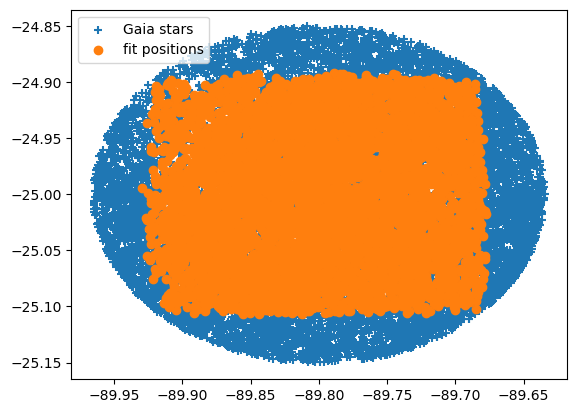

In [122]:
plt.scatter(gaiaCat['coord_ra'].to(u.degree) - 360 * u.degree, gaiaCat['coord_dec'].to(u.degree), label='Gaia stars', marker='+')
plt.scatter(starCat['starX'], starCat['starY'], label='fit positions')
plt.legend()

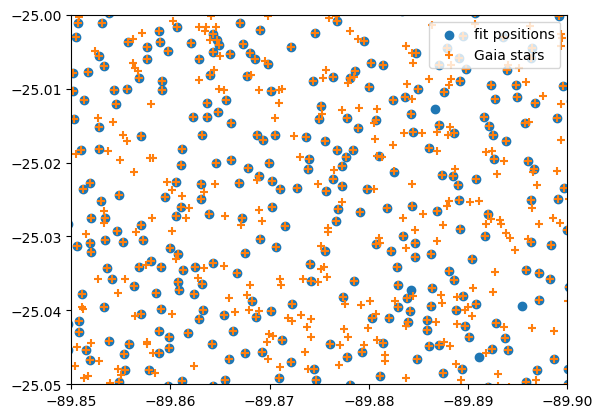

In [128]:
plt.scatter(starCat['starX'], starCat['starY'], label='fit positions')
plt.scatter(gaiaCat['coord_ra'].to(u.degree) - 360 * u.degree, gaiaCat['coord_dec'].to(u.degree), label='Gaia stars', marker='+')
plt.xlim(-89.85, -89.9)
plt.ylim(-25.05, -25.0)
plt.legend()

In [63]:
# Here is a list of all the information in the Gaia catalog:
gaiaCat.colnames

['id',
 'coord_ra',
 'coord_dec',
 'phot_g_mean_flux',
 'phot_bp_mean_flux',
 'phot_rp_mean_flux',
 'phot_g_mean_fluxErr',
 'phot_bp_mean_fluxErr',
 'phot_rp_mean_fluxErr',
 'coord_raErr',
 'coord_decErr',
 'epoch',
 'pm_ra',
 'pm_dec',
 'pm_raErr',
 'pm_decErr',
 'pm_flag',
 'parallax',
 'parallaxErr',
 'parallax_flag',
 'coord_ra_coord_dec_Cov',
 'coord_ra_pm_ra_Cov',
 'coord_ra_pm_dec_Cov',
 'coord_ra_parallax_Cov',
 'coord_dec_pm_ra_Cov',
 'coord_dec_pm_dec_Cov',
 'coord_dec_parallax_Cov',
 'pm_ra_pm_dec_Cov',
 'pm_ra_parallax_Cov',
 'pm_dec_parallax_Cov',
 'astrometric_excess_noise']

## Accessing the original source catalogs (RA and Decs come from fit between individual detector and the reference catalog):

In [30]:
srcs = list(butler.registry.queryDatasets('sourceTable_visit', tract=5634, skymap='latiss_v1', band='r'))
src = butler.get(srcs[0])
src

,coord_ra,coord_dec,ccdVisitId,parentSourceId,x,y,xErr,yErr,ra,dec,...,hsmShapeRegauss_flag_galsim,hsmShapeRegauss_flag_no_pixels,hsmShapeRegauss_flag_not_contained,hsmShapeRegauss_flag_parent_source,sky_source,detect_isPrimary,visit,detector,band,physical_filter
sourceId,,,,,,,,,,,,,,,,,,,,,
172052246308061185,270.183142,-24.994208,41020452096,0,442.000000,26.000000,NaN,NaN,270.183142,-24.994208,...,False,False,False,False,False,True,2023052300621,0,r,SDSSr_65mm~empty
172052246308061186,270.178182,-24.994660,41020452096,0,612.000000,26.000000,NaN,NaN,270.178182,-24.994660,...,False,False,False,False,False,True,2023052300621,0,r,SDSSr_65mm~empty
172052246308061187,270.164994,-24.995862,41020452096,0,1064.000000,26.000000,NaN,NaN,270.164994,-24.995862,...,False,False,False,False,False,True,2023052300621,0,r,SDSSr_65mm~empty
172052246308061188,270.161026,-24.996223,41020452096,0,1200.000000,26.000000,NaN,NaN,270.161026,-24.996223,...,False,False,False,True,False,False,2023052300621,0,r,SDSSr_65mm~empty
172052246308061189,270.130284,-24.999331,41020452096,0,2254.761596,37.718036,3.180406,0.803548,270.130284,-24.999331,...,False,False,False,False,False,True,2023052300621,0,r,SDSSr_65mm~empty
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
172052246308061957,270.100261,-25.104296,41020452096,172052246308061701,3666.701111,3864.776073,0.731167,0.628457,270.100261,-25.104296,...,True,False,False,False,False,True,2023052300621,0,r,SDSSr_65mm~empty
172052246308061958,270.198590,-25.097850,41020452096,172052246308061713,309.000000,3958.000000,NaN,NaN,270.198590,-25.097850,...,False,False,False,False,False,True,2023052300621,0,r,SDSSr_65mm~empty
172052246308061959,270.197135,-25.098036,41020452096,172052246308061713,359.000000,3960.000000,NaN,NaN,270.197135,-25.098036,...,False,False,False,False,False,True,2023052300621,0,r,SDSSr_65mm~empty


## Use the magnitudes from the ATLAS catalog to get colors:
This is the catalog being used as the starting point for photometric calibration for LATISS data. We'll use it to get colors, but the `objectTable` produced from the stacked images could also be used.

In [8]:
atlasRefs = butler.registry.queryDatasets('atlas_refcat2_20220201', tract=5634, skymap='latiss_v1').expanded()
dataIds = [ref.dataId for ref in atlasRefs]
refCats = [butler.getDeferred(ref) for ref in atlasRefs]
atlasLoader = ReferenceObjectLoader(dataIds=dataIds,
                                    refCats=refCats)

In [14]:
atlasCat = butler.get(list(atlasRefs)[0])
atlasCat.getSchema()

Schema(
    (Field['L'](name="id", doc="unique ID"), Key<L>(offset=0, nElements=1)),
    (Field['Angle'](name="coord_ra", doc="position in ra/dec"), Key<Angle>(offset=8, nElements=1)),
    (Field['Angle'](name="coord_dec", doc="position in ra/dec"), Key<Angle>(offset=16, nElements=1)),
    (Field['D'](name="g_flux", doc="flux in filter g", units="nJy"), Key<D>(offset=24, nElements=1)),
    (Field['D'](name="r_flux", doc="flux in filter r", units="nJy"), Key<D>(offset=32, nElements=1)),
    (Field['D'](name="i_flux", doc="flux in filter i", units="nJy"), Key<D>(offset=40, nElements=1)),
    (Field['D'](name="z_flux", doc="flux in filter z", units="nJy"), Key<D>(offset=48, nElements=1)),
    (Field['D'](name="g_fluxErr", doc="flux uncertainty in filter g", units="nJy"), Key<D>(offset=56, nElements=1)),
    (Field['D'](name="r_fluxErr", doc="flux uncertainty in filter r", units="nJy"), Key<D>(offset=64, nElements=1)),
    (Field['D'](name="i_fluxErr", doc="flux uncertainty in filter i", u

In [33]:
ctr = lsst.geom.SpherePoint(-89.8, -25, lsst.geom.degrees)
radius = 0.15 * lsst.geom.degrees
#epoch = Time(np.median(mjds), format='mjd')
atlasCatG = atlasLoader.loadSkyCircle(ctr, radius, filterName='g').refCat.asAstropy()
atlasCatR = atlasLoader.loadSkyCircle(ctr, radius, filterName='r').refCat.asAstropy()
atlasCatI = atlasLoader.loadSkyCircle(ctr, radius, filterName='i').refCat.asAstropy()
atlasGR = atlasCatG['g_flux'].to(u.ABmag) - atlasCatR['r_flux'].to(u.ABmag)
atlasRI = atlasCatR['r_flux'].to(u.ABmag) - atlasCatI['i_flux'].to(u.ABmag)

In [38]:
# Use astropy.coordinates.SkyCoord to match the objects in the objectTable with the starCatalog:
atlasCoords = SkyCoord(ra=atlasCatR['coord_ra'], dec=atlasCatR['coord_dec'])
starCoords = SkyCoord(ra=starCat['starX'].to_numpy() * u.degree, dec=starCat['starY'].to_numpy() * u.degree)

id, d2d, d3d = starCoords.match_to_catalog_sky(atlasCoords)
goodInds = d2d.arcsecond < 1
print(len(starCoords), goodInds.sum())

# We will denote missing color information with NaNs
starCatGR = np.ones(len(starCat)) * np.nan
starCatGR[goodInds] = atlasGR[id[goodInds]]
starCatRI = np.ones(len(starCat)) * np.nan
starCatRI[goodInds] = atlasRI[id[goodInds]]

4628 4541


Text(0, 0.5, 'R - I')

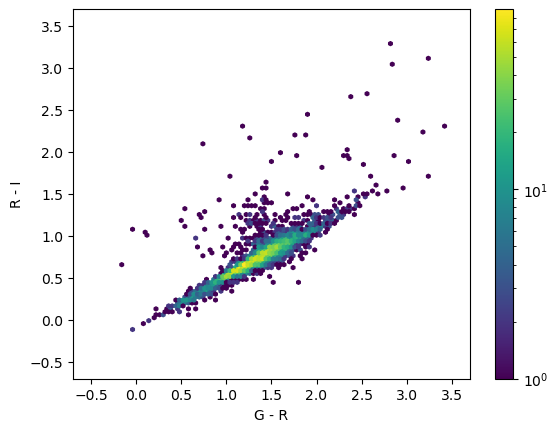

In [43]:
# Here's a color-color plot for the objects in the starCat:
plt.hexbin(starCatGR, starCatRI, extent=[-0.5, 3.5, -0.5, 3.5], bins='log')
plt.colorbar()
plt.xlabel('G - R')
plt.ylabel('R - I')